In [1]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower
from scipy.interpolate import interp1d
import pickle

import importlib.util
import sys

In [2]:
test_index = 1
validation_set = False
# skips comparison with Andrea's code
fast = False

In [3]:
''' This messiness is necessary to import scripts which are not installed and
which are not located in the cwd.'''

spec = importlib.util.spec_from_file_location(
    "camb_interface", "../../../cassL/camb_interface.py")
ci = importlib.util.module_from_spec(spec)
sys.modules["camb_interface"] = ci
spec.loader.exec_module(ci)

spec = importlib.util.spec_from_file_location(
    "generate_emu_data", "../../../cassL/generate_emu_data.py")
ged = importlib.util.module_from_spec(spec)
sys.modules["generate_emu_data"] = ged
spec.loader.exec_module(ged)

spec = importlib.util.spec_from_file_location(
    "andreap", "../andreap.py")
andreap = importlib.util.module_from_spec(spec)
sys.modules["andreap"] = andreap
spec.loader.exec_module(andreap)

In [4]:
# Get the latin hypercubes so that we know which values to use for our test
# cosmological configurations.

hc = np.load("../G_versions/hc_backup_i49_G6.npy",
    allow_pickle=True)

standard_k = np.load("../standard_k.npy", allow_pickle=True)

In [5]:
# Select an individual cosmology to interrogate
test_cosmology = hc[test_index]

In [6]:
# Break the configuration into explicit labels
ombh2 = test_cosmology[0]
omch2 = test_cosmology[1]
ns = test_cosmology[2]
sigma12 = test_cosmology[3]
As = test_cosmology[4]
omnuh2 = test_cosmology[5]

In [7]:
# Get an emulator-readable cosmology object based off of these parameters
full_cosm = ged.build_cosmology(ombh2, omch2, ns, sigma12, As, omnuh2)

In [8]:
# What would we get if we called CAMB again on this configuration?
g_pspec, g_sigma12, g_rescale = ged.interpolate_cell(full_cosm, standard_k)
g_z = g_rescale[1]
print("This is our approximation", g_sigma12)

nnu_massive: 0
nnu_massive: 1
This is our approximation 0.8624800748159258


In [9]:
andrea_Pk = andreap.get_PK(ombh2, omch2, ns, full_cosm['omnuh2'], 67, As)
# andrea_Pk = andreap.get_PK_doubtful(ombh2, omch2, ns, full_cosm['mnu'], 67, As)

In [10]:
# FOR THIS PARTICULAR TEST CASE (index 400, training set), h was not moved, and
# the following line is accurate
andrea_spectrum = andrea_Pk['mnu'].P(g_z, standard_k)

Text(0.5, 1.0, "Andrea's power spectrum vs. Lukas' emu training spectrum")

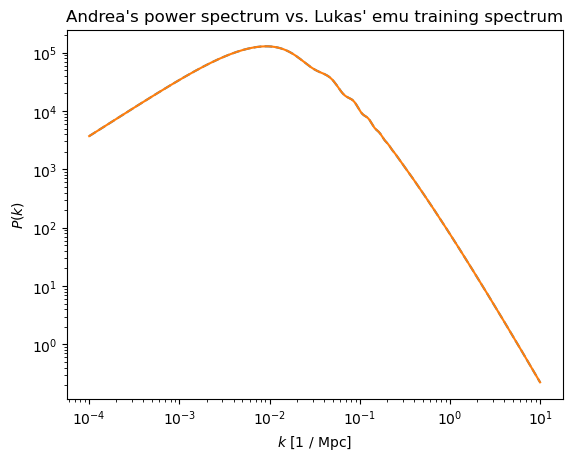

In [11]:
# Overplot comparison: Andrea's spectrum vs mine
plt.loglog(standard_k, andrea_spectrum, linestyle='dashed')
plt.loglog(standard_k, g_pspec)
plt.xlabel('$k$ [1 / Mpc]')
plt.ylabel('$P(k)$')
plt.title('Andrea\'s power spectrum vs. Lukas\' emu training spectrum')

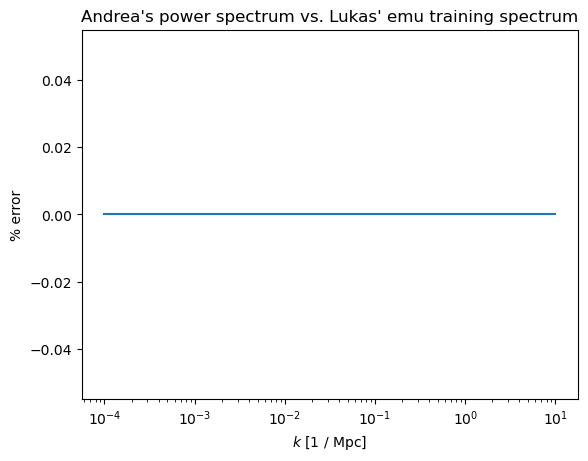

In [12]:
# Percent error comparison
plt.plot(standard_k,
         (g_pspec - andrea_spectrum) / andrea_spectrum * 100)
plt.xscale('log')
plt.xlabel('$k$ [1 / Mpc]')
plt.ylabel('% error')
plt.title('Andrea\'s power spectrum vs. Lukas\' emu training spectrum')
plt.savefig("../../plots/emulator/debugging/Andrea_old_discrepancy.png")